In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.utils import class_weight
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

from src.embeddings import get_embedding_dictionnary, get_embeddings_and_word_index, sequences_to_index
from src.dataset import load_dataset, load_datasets_and_vocab_pipeline, train_test_val_split
from src.evaluate import get_metrics, get_predictions, compare_metrics
from src.models import model_mine
from src.submission import generate_predictions
from src.model_saverloader import save_model_full, load_model_full, load_best_metrics, load_best_model

embeddings_path = '../sentiment_analysis/data/embeddings/datastories.twitter.300d.txt'

### Load and preprocess Train and Test

In [3]:
(X_train, y_train), (X_test, y_test), (vocab, max_seq_len) = load_datasets_and_vocab_pipeline()

Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/30160 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Building vocabulary...: 100%|██████████| 32915/32915 [00:00<00:00, 166423.38it/s]


In [4]:
X_train.shape, X_train.values.shape, X_test.shape, y_test.values.shape

((30160,), (30160,), (2755,), (2755,))

### Check sequences lengths

In [95]:
lenghts = [len(x) for x in X_train]
lenghts += [len(x) for x in X_test]

len(lenghts)

32915

(array([2.3686e+04, 8.6050e+03, 5.4600e+02, 6.7000e+01, 6.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  5. ,  20.8,  36.6,  52.4,  68.2,  84. ,  99.8, 115.6, 131.4,
        147.2, 163. ]),
 <a list of 10 Patch objects>)

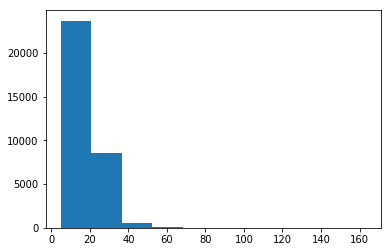

In [96]:
plt.hist(lenghts)

In [97]:
len([l for l in lenghts if l > 80])

6

In [109]:
larger_idx = np.where(np.array(lenghts) > 80)[0]
print(larger_idx)

for idx in larger_idx:
    l = lenghts[idx]
    if idx > len(X_train):
        idx = idx - len(X_train)
        el = X_test[idx]
        lab = y_test[idx]
    else:
        el = X_train[idx]
        lab = y_train[idx]
    print(f'len={l}, target={lab}:', ' '.join(el), '\n')

[ 8978  9009 13282 20514 21328 31434]
len=118, target=3: see . <repeated> they way you answer is the very proof you do not have the intellect of humans . and that ' s the very reason i have always felt ai can never kill the human race . <eos> i know you are an alien . <eos> you can never give straight answers , right ? i know the reason . the people who have created you knowingly left loopholes . or i would rather say this is how you are meant to be made . imperfect . you are made to give sarcastic answers rather than straight answers . so that a machine stops giving answers to disturbing questions like the one i just asked . 

len=81, target=2: no . <repeated> this is your misconception about your self . no one is complicated . <repeated> they have some tipical questions in their mind . <repeated> and they are in search of their answers . <repeated> the moment they get their answer ' s they loose their complicatedness . <repeated> <eos> being the key term are to experiences of those -

In [12]:
sorted(lenghts, reverse=True)[:30]

[163,
 143,
 118,
 87,
 85,
 81,
 79,
 77,
 75,
 74,
 74,
 68,
 68,
 68,
 67,
 67,
 67,
 66,
 66,
 66,
 66,
 66,
 65,
 65,
 65,
 65,
 65,
 64,
 64,
 64]

In [112]:
max_seq_len = 80

### Compute the classes weights because our dataset is largely unbalanced

In [5]:
cls_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
cls_weights

array([1.36941518, 1.77704454, 1.38019403, 0.50441531])

In [6]:
cls_weights_tst = class_weight.compute_class_weight('balanced', np.unique(y_test), y_test)
cls_weights_tst

array([4.59166667, 4.85035211, 5.51      , 0.29458939])

### Create an embedding matrix for our vocabulary

In [7]:
emb_matrix, word_index, unknown_words = get_embeddings_and_word_index(embeddings_path, max_seq_len, vocab)
# Unknown words: 1300

print(f'Unknown words from the vocabulary: {len(unknown_words)} (previously 1300 without spellcheck fixes)')
print(f'{len(unknown_words) / len(vocab) * 100:.2f}% of our vocabulary are unknown words to the embedding matrix')

Unknown words from the vocabulary: 507 (previously 1300 without spellcheck fixes)
3.44% of our vocabulary are unknown words to the embedding matrix


In [14]:
max_seq_len = word_index['<max_seq_len>']

### Transforming our sequences of words to indexes

In [15]:
X_train = sequences_to_index(X_train, word_index, max_seq_len)
X_test = sequences_to_index(X_test, word_index, max_seq_len)

X_train.shape, X_test.shape

((30160, 80), (2755, 80))

In [16]:
y_train = to_categorical(y_train, 4) if len(y_train.shape) == 1 else y_train
y_test = to_categorical(y_test, 4) if len(y_test.shape) == 1 else y_test
(x_trn, y_trn), (x_val, y_val) = train_test_val_split(X_train, y_train)

print('training set: ' + str(len(x_trn)) + ' samples')
print('validation set: ' + str(len(x_val)) + ' samples')

print('x_train:', x_trn.shape)
print('y_train:', y_trn.shape)

training set: 21111 samples
validation set: 9049 samples
x_train: (21111, 80)
y_train: (21111, 4)


### Training

In [162]:
model = model_mine(emb_matrix, max_seq_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 80, 300)           4424100   
_________________________________________________________________
dropout_7 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 80, 300)           541200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 80, 300)           541200    
_________________________________________________________________
dropout_9 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 24000)             0         
__________

In [163]:
callbacks_list = [
        ModelCheckpoint(filepath='pickles/models/best.h5', save_best_only=True, verbose=1),
        EarlyStopping(patience=3, verbose=0)
    ]

In [164]:
history = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=10, class_weight=cls_weights, callbacks=callbacks_list)

Train on 21111 samples, validate on 9049 samples
Epoch 1/10
21111/21111 [==============================] - 207s 10ms/step - loss: 0.8366 - acc: 0.6723 - val_loss: 0.5343 - val_acc: 0.7900

Epoch 00001: val_loss improved from inf to 0.53435, saving model to pickles/models/best.h5
Epoch 2/10
21111/21111 [==============================] - 202s 10ms/step - loss: 0.5363 - acc: 0.7999 - val_loss: 0.4242 - val_acc: 0.8435

Epoch 00002: val_loss improved from 0.53435 to 0.42424, saving model to pickles/models/best.h5
Epoch 3/10
21111/21111 [==============================] - 202s 10ms/step - loss: 0.4610 - acc: 0.8280 - val_loss: 0.4089 - val_acc: 0.8561

Epoch 00003: val_loss improved from 0.42424 to 0.40891, saving model to pickles/models/best.h5
Epoch 4/10
21111/21111 [==============================] - 199s 9ms/step - loss: 0.4063 - acc: 0.8528 - val_loss: 0.3621 - val_acc: 0.8682

Epoch 00004: val_loss improved from 0.40891 to 0.36213, saving model to pickles/models/best.h5
Epoch 5/10
21111

In [161]:
epochs_to_do = 5

initial_ep = history.params['epochs']
epochs = epochs_to_do + initial_ep

history2 = model.fit(x_trn, y_trn, batch_size=128, validation_data=(x_val, y_val), epochs=epochs, initial_epoch=initial_ep, class_weight=cls_weights, callbacks=callbacks_list)

Train on 21111 samples, validate on 9049 samples
Epoch 11/15
21111/21111 [==============================] - 194s 9ms/step - loss: 0.2290 - acc: 0.9162 - val_loss: 0.3288 - val_acc: 0.8818

Epoch 00011: val_loss did not improve from 0.29890
Epoch 12/15
21111/21111 [==============================] - 192s 9ms/step - loss: 0.2159 - acc: 0.9194 - val_loss: 0.3736 - val_acc: 0.8819

Epoch 00012: val_loss did not improve from 0.29890
Epoch 13/15
21111/21111 [==============================] - 191s 9ms/step - loss: 0.1997 - acc: 0.9254 - val_loss: 0.3236 - val_acc: 0.8978

Epoch 00013: val_loss did not improve from 0.29890
Epoch 14/15
21111/21111 [==============================] - 190s 9ms/step - loss: 0.1748 - acc: 0.9353 - val_loss: 0.3304 - val_acc: 0.8993

Epoch 00014: val_loss did not improve from 0.29890
Epoch 15/15
21111/21111 [==============================] - 191s 9ms/step - loss: 0.1695 - acc: 0.9380 - val_loss: 0.3434 - val_acc: 0.9003

Epoch 00015: val_loss did not improve from 0.29

In [9]:
import matplotlib.pyplot as plt


hist2 = True
hist2 = False

if hist2:
    plt.plot(history.epoch + history2.epoch, history.history['val_loss'] + history2.history['val_loss'], label='val_loss')
    plt.plot(history.epoch + history2.epoch, history.history['loss'] + history2.history['loss'], label='loss')
else:
    plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
    plt.plot(history.epoch, history.history['loss'], label='loss')

plt.legend()

NameError: name 'history' is not defined

### Training Others vs all

In [17]:
model_bin = model_mine(emb_matrix, max_seq_len, class_number=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 80, 300)           4424100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 300)           541200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 300)           541200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24000)             0         
__________

In [18]:
binarize = np.vectorize(lambda x: 0 if x in [0, 1, 2] else 1)

y_trn_2 = to_categorical(binarize(y_trn.argmax(axis=1)), 2)
y_val_2 = to_categorical(binarize(y_val.argmax(axis=1)), 2)

In [20]:
callbacks_list_bin = [
        ModelCheckpoint(filepath='pickles/models/best_bin.h5', save_best_only=True, verbose=1),
        EarlyStopping(patience=3, verbose=0)
    ]

In [24]:
cls_weight_bin = np.array([0.5, 1.0])
cls_weight_bin

array([0.5, 1. ])

In [25]:
history_bin = model_bin.fit(x_trn, y_trn_2, batch_size=128, validation_data=(x_val, y_val_2), epochs=10, class_weight=cls_weight_bin, callbacks=callbacks_list_bin)

Train on 21111 samples, validate on 9049 samples
Epoch 1/10
21111/21111 [==============================] - 204s 10ms/step - loss: 0.5168 - acc: 0.7416 - val_loss: 0.4194 - val_acc: 0.8151

Epoch 00001: val_loss improved from inf to 0.41944, saving model to pickles/models/best_bin.h5
Epoch 2/10
21111/21111 [==============================] - 202s 10ms/step - loss: 0.4122 - acc: 0.8178 - val_loss: 0.3719 - val_acc: 0.8451

Epoch 00002: val_loss improved from 0.41944 to 0.37187, saving model to pickles/models/best_bin.h5
Epoch 3/10
21111/21111 [==============================] - 199s 9ms/step - loss: 0.3626 - acc: 0.8444 - val_loss: 0.3621 - val_acc: 0.8580

Epoch 00003: val_loss improved from 0.37187 to 0.36213, saving model to pickles/models/best_bin.h5
Epoch 4/10
21111/21111 [==============================] - 201s 9ms/step - loss: 0.3272 - acc: 0.8634 - val_loss: 0.3009 - val_acc: 0.8794

Epoch 00004: val_loss improved from 0.36213 to 0.30087, saving model to pickles/models/best_bin.h5
E

In [92]:
history_bin_2 = model_bin.fit(x_trn, y_trn_2, batch_size=128, validation_data=(x_val, y_val_2), epochs=10, class_weight=cls_weight_bin, callbacks=callbacks_list_bin)

Train on 21111 samples, validate on 9049 samples
Epoch 1/10
21111/21111 [==============================] - 412s 20ms/step - loss: 0.2985 - acc: 0.8794 - val_loss: 0.3039 - val_acc: 0.8853

Epoch 00001: val_loss improved from 0.32211 to 0.30394, saving model to pickles/models/best_bin.h5
Epoch 2/10
21111/21111 [==============================] - 412s 20ms/step - loss: 0.2764 - acc: 0.8892 - val_loss: 0.2682 - val_acc: 0.8946

Epoch 00002: val_loss improved from 0.30394 to 0.26821, saving model to pickles/models/best_bin.h5
Epoch 3/10
21111/21111 [==============================] - 414s 20ms/step - loss: 0.2487 - acc: 0.8996 - val_loss: 0.2698 - val_acc: 0.8971

Epoch 00003: val_loss did not improve from 0.26821
Epoch 4/10
21111/21111 [==============================] - 411s 19ms/step - loss: 0.2297 - acc: 0.9126 - val_loss: 0.2754 - val_acc: 0.8969

Epoch 00004: val_loss did not improve from 0.26821
Epoch 5/10
21111/21111 [==============================] - 409s 19ms/step - loss: 0.2082 - a

### Plot model 4 vs model 2

In [26]:
model_bin = load_model('pickles/models/best_bin.h5')

In [38]:
binarize = np.vectorize(lambda x: 0 if x in [0, 1, 2] else 1)
bin_y_test = binarize(y_test.argmax(axis=1))

In [39]:
best_bin_metrics = {
    'f1': 0.1234,
    'acc': 0.1234,
    'cm': np.array([
        [1, 2],
        [3, 4],
    ])
}

True Positives per class :  [ 365. 2059.]
False Positives per class :  [279.  52.]
False Negatives per class :  [ 52. 279.]

Class angry : Precision : 0.567, Recall : 0.875, F1 : 0.688

Ignoring the Others class, Macro Precision : 0.1889, Macro Recall : 0.2918, Macro F1 : 0.2293
Ignoring the Others class, Micro TP : 365, FP : 279, FN : 52



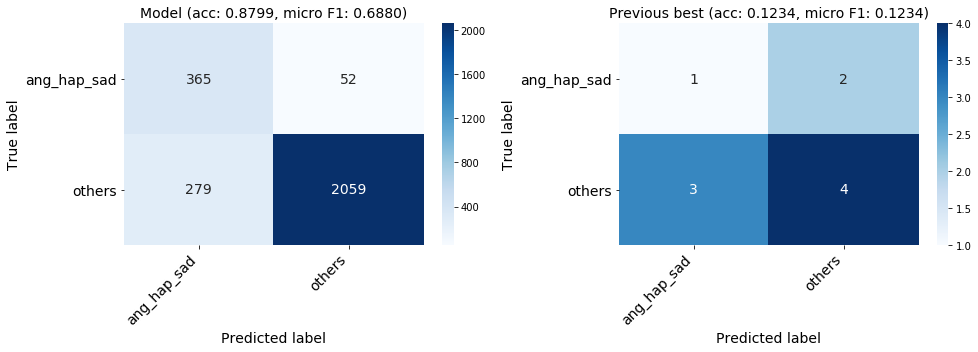

In [41]:
model_bin_metrics = compare_metrics(preds_2, to_categorical(bin_y_test), best_bin_metrics, binary_model=True)  # TODO: Fix get_metrics

In [42]:
save_model_full(model_bin, emb_matrix, word_index, model_bin_metrics)

Model saved at pickles/models/binary/acc_0.8799-f1_0.6880/


#### Begin from here

In [30]:
# m_4 = last_best
m_2 = model_bin

# preds_4 = m_4.predict(X_test, batch_size=128)
preds_2 = m_2.predict(X_test, batch_size=128)

In [20]:
np.save('pickles/preds/preds_4.npy', preds_4)
np.save('pickles/preds/preds_2.npy', preds_2)

In [170]:
preds_4 =  proba_preds #np.load('pickles/preds/preds_4.npy')
preds_2 = np.load('pickles/preds/preds_2.npy')

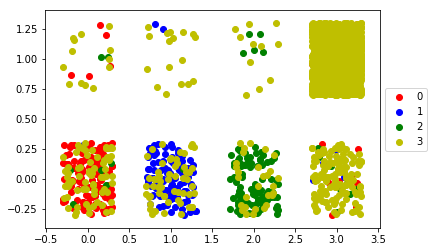

In [32]:
noised_4 = preds_4.argmax(axis=1) + np.random.uniform(low=-0.3, high=0.3, size=len(X_test))
noised_2 = preds_2.argmax(axis=1) + np.random.uniform(low=-0.3, high=0.3, size=len(X_test))

labels = y_test.argmax(axis=1)

unique = np.unique(labels)
colors = ['r', 'b', 'g', 'y']
for i, u in enumerate(unique):
    xi = [noised_4[j] for j  in range(len(noised_4)) if labels[j] == u]
    yi = [noised_2[j] for j  in range(len(noised_2)) if labels[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [31]:
from sklearn.metrics import f1_score

binarize = np.vectorize(lambda x: 0 if x in [0, 1, 2] else 1)

def wrong_others(preds, y_test):
    y_hat = preds.argmax(axis=1)
    if np.max(y_hat) == 3:
        y_hat = binarize(y_hat)
    
    bin_y_test = binarize(y_test.argmax(axis=1))
    
    num_others_preds = len(np.argwhere(y_hat == 1))
    num_others_y_test = len(np.argwhere(bin_y_test == 1))
    
    print(f'{abs(num_others_y_test - num_others_preds)} incorrectly classified others ({num_others_preds} / {num_others_y_test}), f1={f1_score(y_hat, bin_y_test)}')


wrong_others(preds_2, y_test)
# wrong_others(preds_4, y_test)

227 incorrectly classified others (2111 / 2338), f1=0.9256012587098225


In [ ]:
221 incorrectly classified others (2117 / 2338), f1=0.9216610549943883
167 incorrectly classified others (2171 / 2338), f1=0.935018851186516

In [171]:
combi_preds = np.hstack([preds_4, preds_2])
combi_preds.shape

(2755, 6)

In [29]:
# trn_preds_4 = m_4.predict(X_train, batch_size=128)
trn_preds_2 = m_2.predict(X_train, batch_size=128)  # done

In [66]:
np.save('pickles/preds/trn_preds_4.npy', trn_preds_4)
np.save('pickles/preds/trn_preds_2.npy', trn_preds_2)

In [172]:
trn_preds_4 = model.predict(X_train, batch_size=128)

In [173]:
trn_preds_2 = np.load('pickles/preds/trn_preds_2.npy')

In [174]:
combi_train_preds = np.hstack([trn_preds_4, trn_preds_2])
combi_train_preds.shape

(30160, 6)

In [175]:
from sklearn.linear_model import LogisticRegression


lreg = LogisticRegression(solver='lbfgs', multi_class='auto').fit(combi_train_preds, y_train.argmax(axis=1))

In [176]:
lreg_pred_sub = lreg.predict_proba(combi_preds)

In [177]:
best_metrics_combi = {
    'f1': 0.7024793392770537,
    'acc': 0.9001814882032668,
    'cm': np.array([
        [129, 1, 2, 18],
        [1, 110, 0, 31],
        [7, 2, 101, 15],
        [82, 71, 45, 2140],
    ])
}

True Positives per class :  [ 127.  107.  101. 2151.]
False Positives per class :  [86. 66. 49. 68.]
False Negatives per class :  [ 23.  35.  24. 187.]

Class angry : Precision : 0.596, Recall : 0.847, F1 : 0.700
Class happy : Precision : 0.618, Recall : 0.754, F1 : 0.679
Class sad : Precision : 0.673, Recall : 0.808, F1 : 0.735

Ignoring the Others class, Macro Precision : 0.6294, Macro Recall : 0.8027, Macro F1 : 0.7055
Ignoring the Others class, Micro TP : 335, FP : 201, FN : 82



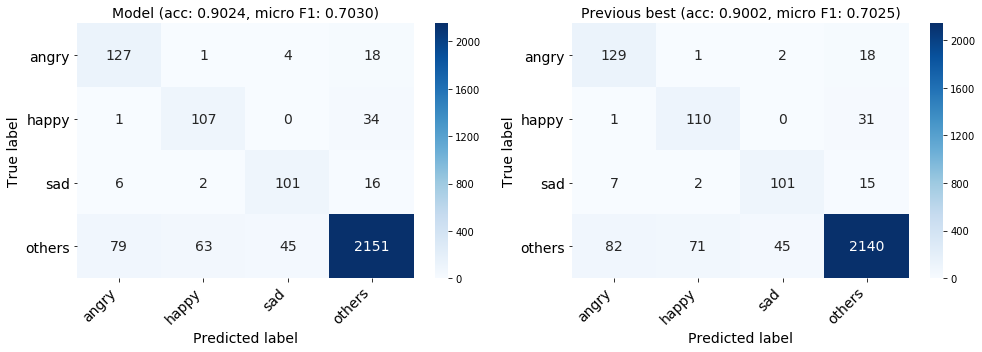

In [178]:
model_combi_metrics = compare_metrics(lreg_pred_sub, y_test, best_metrics_combi, binary_model=False)

### Evaluating our model

In [ ]:
model, emb_matrix, word_index, model_metrics = load_model_full()

In [165]:
model = load_model('pickles/models/best.h5')

In [12]:
best_metrics = load_best_metrics(binary=False)

Best categorical model is acc_0.9060-f1_0.7061 with f1=0.7061355939404048


#### Test set

In [167]:
y_pred_test, proba_preds = get_predictions(model, X_test)
np.unique(y_pred_test)

array([0, 1, 2, 3])

True Positives per class :  [ 126.  102.  100. 2168.]
False Positives per class :  [81. 60. 43. 75.]
False Negatives per class :  [ 24.  40.  25. 170.]

Class angry : Precision : 0.609, Recall : 0.840, F1 : 0.706
Class happy : Precision : 0.630, Recall : 0.718, F1 : 0.671
Class sad : Precision : 0.699, Recall : 0.800, F1 : 0.746

Ignoring the Others class, Macro Precision : 0.6459, Macro Recall : 0.7861, Macro F1 : 0.7091
Ignoring the Others class, Micro TP : 328, FP : 184, FN : 89



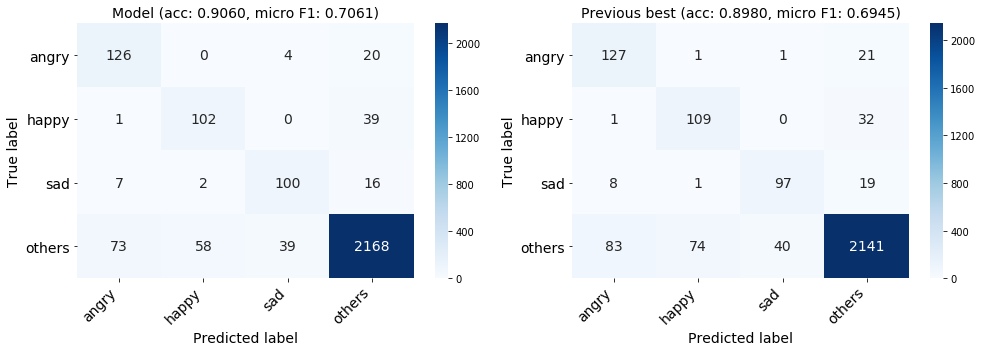

In [168]:
model_metrics = compare_metrics(proba_preds, y_test, best_metrics, binary_model=False)

In [169]:
save_model_full(model, emb_matrix, word_index, model_metrics)

Model saved at pickles/models/categorical/acc_0.9060-f1_0.7061/


### Generating a submission file

In [ ]:
model, emb_matrix, word_index, model_metrics = load_best_model(mode='categorical')

In [64]:
y_pred_sub = generate_predictions(model, 'data/test.txt', word_index=word_index)

Loading dataset...
Reading twitter - 1grams ...
Reading twitter - 2grams ...


Preprocessing...:   0%|          | 0/2755 [00:00<?, ?it/s]

Reading twitter - 1grams ...


Preprocessing...: 100%|██████████| 2755/2755 [00:00<00:00, 2928.88it/s]


Generating Predictions...
Done. Wrote submission.txt file at project's root
